In [4]:
!pip install tensorflow
!pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 50.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.8/294.8 kB 30.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 81.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 41.8 MB/s eta 0:00:00


In [5]:
import pandas as pd
import numpy as np

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from transformers import AutoModelForSequenceClassification

import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

In [6]:
with open("/train_data.txt", 'r') as file:
    print(f"First line (header) looks like this:\n\n{file.readline()}")
    print(f"Each data point looks like this:\n\n{file.readline()}")

First line (header) looks like this:

1 ::: Oscar et la dame rose (2009) ::: drama ::: Listening in to a conversation between his doctor and parents, 10-year-old Oscar learns what nobody has the courage to tell him. He only has a few weeks to live. Furious, he refuses to speak to anyone except straight-talking Rose, the lady in pink he meets on the hospital stairs. As Christmas approaches, Rose uses her fantastical experiences as a professional wrestler, her imagination, wit and charm to allow Oscar to live life and love to the full, in the company of his friends Pop Corn, Einstein, Bacon and childhood sweetheart Peggy Blue.

Each data point looks like this:

2 ::: Cupid (1997) ::: thriller ::: A brother and sister with a past incestuous relationship have a current murderous relationship. He murders the women who reject him and she murders the women who get too close to him.



In [7]:
NUM_WORDS = 5000
EMBEDDING_DIM = 16
MAXLEN = 250
PADDING = 'post'
OOV_TOKEN = "<OOV>"

In [8]:
def remove_stopwords(sentence):
    stopwords = ["a", "about", "above", "after", "again", "against", "all", "am", "an", "and", "any", "are", "as", "at", "be", "because", "been", "before", "being", "below", "between", "both", "but", "by", "could", "did", "do", "does", "doing", "down", "during", "each", "few", "for", "from", "further", "had", "has", "have", "having", "he", "he'd", "he'll", "he's", "her", "here", "here's", "hers", "herself", "him", "himself", "his", "how", "how's", "i", "i'd", "i'll", "i'm", "i've", "if", "in", "into", "is", "it", "it's", "its", "itself", "let's", "me", "more", "most", "my", "myself", "nor", "of", "on", "once", "only", "or", "other", "ought", "our", "ours", "ourselves", "out", "over", "own", "same", "she", "she'd", "she'll", "she's", "should", "so", "some", "such", "than", "that", "that's", "the", "their", "theirs", "them", "themselves", "then", "there", "there's", "these", "they", "they'd", "they'll", "they're", "they've", "this", "those", "through", "to", "too", "under", "until", "up", "very", "was", "we", "we'd", "we'll", "we're", "we've", "were", "what", "what's", "when", "when's", "where", "where's", "which", "while", "who", "who's", "whom", "why", "why's", "with", "would", "you", "you'd", "you'll", "you're", "you've", "your", "yours", "yourself", "yourselves" ]

    sentence = sentence.lower()

    words = sentence.split()
    no_words = [w for w in words if w not in stopwords]
    sentence = " ".join(no_words)

    return sentence


def parse_data_from_file(filename):
    sentences = []
    labels = []

    with open(filename, 'r') as file:
        for line in file:
            values = line.strip().split(':::')
            labels.append(values[2])
            sentence = values[3]
            sentence = remove_stopwords(sentence)
            sentences.append(sentence)

    return sentences, labels

In [10]:
sentences, labels = parse_data_from_file("/train_data.txt")

print(f"There are {len(sentences)} sentences in the dataset.\n")
print(f"First sentence has {len(sentences[0].split())} words (after removing stopwords).\n")
print(f"There are {len(labels)} labels in the dataset.\n")
print(f"The first 5 labels are {labels[:5]}")

There are 54214 sentences in the dataset.

First sentence has 52 words (after removing stopwords).

There are 54214 labels in the dataset.

The first 5 labels are [' drama ', ' thriller ', ' adult ', ' drama ', ' drama ']


In [11]:
print(sentences[0])

listening conversation doctor parents, 10-year-old oscar learns nobody courage tell him. weeks live. furious, refuses speak anyone except straight-talking rose, lady pink meets hospital stairs. christmas approaches, rose uses fantastical experiences professional wrestler, imagination, wit charm allow oscar live life love full, company friends pop corn, einstein, bacon childhood sweetheart peggy blue.


In [12]:
test_sentences, test_labels = parse_data_from_file("/test_data_solution.txt")

print(f"There are {len(test_sentences)} sentences in the dataset.\n")
print(f"First sentence has {len(test_sentences[0].split())} words (after removing stopwords).\n")
print(f"There are {len(test_labels)} labels in the dataset.\n")
print(f"The first 5 labels are {test_labels[:5]}")

There are 54200 sentences in the dataset.

First sentence has 53 words (after removing stopwords).

There are 54200 labels in the dataset.

The first 5 labels are [' thriller ', ' comedy ', ' documentary ', ' drama ', ' drama ']


In [13]:
print(f"There are {len(sentences)} sentences for training.\n")
print(f"There are {len(labels)} labels for training.\n")
print(f"There are {len(test_sentences)} sentences for validation.\n")
print(f"There are {len(test_labels)} labels for validation.")

There are 54214 sentences for training.

There are 54214 labels for training.

There are 54200 sentences for validation.

There are 54200 labels for validation.


In [14]:
def fit_tokenizer(train_sentences, num_words, oov_token):
    tokenizer = Tokenizer(oov_token = oov_token, num_words = num_words)
    tokenizer.fit_on_texts(train_sentences)

    return tokenizer

In [15]:
tokenizer = fit_tokenizer(sentences, NUM_WORDS, OOV_TOKEN)
word_index = tokenizer.word_index

print(f"Vocabulary contains {len(word_index)} words\n")
print("<OOV> token included in vocabulary" if "<OOV>" in word_index else "<OOV> token NOT included in vocabulary")



Vocabulary contains 138429 words

<OOV> token included in vocabulary


In [16]:
def seq_and_pad(sentences, tokenizer, padding, maxlen):
    sequences = tokenizer.texts_to_sequences(sentences)
    padded_sequences = pad_sequences(sequences, maxlen = maxlen, padding = padding)

    return padded_sequences

In [17]:
train_padded_seq = seq_and_pad(sentences, tokenizer, PADDING, MAXLEN)
val_padded_seq = seq_and_pad(test_sentences, tokenizer, PADDING, MAXLEN)

print(f"Padded training sequences have shape: {train_padded_seq.shape}\n")
print(f"Padded validation sequences have shape: {val_padded_seq.shape}")


Padded training sequences have shape: (54214, 250)

Padded validation sequences have shape: (54200, 250)


In [18]:
def remove_special_character(word, special_char='-'):
    return word.replace(special_char, '')

def replace_words_with_special_character(words_list, special_char='-'):
    new_words_list = []
    for word in words_list:
        if special_char in word:
            new_word = remove_special_character(word, special_char)
            new_words_list.append(new_word)
        else:
            new_words_list.append(word)
    return new_words_list

def count_unique_elements(input_list):
    unique_elements = set(input_list)
    return len(unique_elements)

In [19]:
labels = replace_words_with_special_character(labels)
test_labels = replace_words_with_special_character(test_labels)

In [20]:
no = count_unique_elements(labels)
no

27

In [21]:
def flatten_list(input_list):
    output_list = []
    for item in input_list:
        if isinstance(item, list):
            output_list.extend(flatten_list(item))
        else:
            output_list.append(item)
    return output_list

In [22]:
def tokenize_labels(labels):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(labels)
    tokenized_labels = tokenizer.texts_to_sequences(labels)
    tokenized_labels = np.array(tokenized_labels) - 1

    return tokenized_labels

In [23]:
train_label_seq = tokenize_labels(labels)
val_label_seq = tokenize_labels(test_labels)

print(f"First 5 labels of the training set should look like this:\n{train_label_seq[:5]}\n")
print(f"First 5 labels of the validation set should look like this:\n{val_label_seq[:5]}\n")
print(f"Tokenized labels of the training set have shape: {train_label_seq.shape}\n")
print(f"Tokenized labels of the validation set have shape: {val_label_seq.shape}\n")


First 5 labels of the training set should look like this:
[[ 0]
 [ 5]
 [14]
 [ 0]
 [ 0]]

First 5 labels of the validation set should look like this:
[[5]
 [2]
 [1]
 [0]
 [0]]

Tokenized labels of the training set have shape: (54214, 1)

Tokenized labels of the validation set have shape: (54200, 1)



In [25]:
def create_model(num_words, embedding_dim, maxlen):
    tf.random.set_seed(123)

    model = tf.keras.Sequential([
        tf.keras.layers.Embedding(num_words, embedding_dim, input_length=maxlen),
        tf.keras.layers.GlobalAveragePooling1D(),
        tf.keras.layers.Dense(1024, activation='relu'),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dropout(0.25),
        tf.keras.layers.Dense(96, activation='relu'),
        tf.keras.layers.Dense(27, activation='softmax'),
    ])

    model.compile(loss="sparse_categorical_crossentropy",
                  optimizer="adam",
                  metrics=['accuracy'])

    return model

In [26]:
model = create_model(NUM_WORDS, EMBEDDING_DIM, MAXLEN)

history = model.fit(train_padded_seq, train_label_seq, epochs=30, validation_data=(val_padded_seq, val_label_seq))


Epoch 1/30
1695/1695 [==============================] - 48s 27ms/step - loss: 2.1059 - accuracy: 0.3615 - val_loss: 1.8354 - val_accuracy: 0.4627
Epoch 2/30
1695/1695 [==============================] - 29s 17ms/step - loss: 1.7621 - accuracy: 0.4725 - val_loss: 1.7459 - val_accuracy: 0.4850
Epoch 3/30
1695/1695 [==============================] - 31s 18ms/step - loss: 1.6483 - accuracy: 0.5128 - val_loss: 1.6538 - val_accuracy: 0.5184
Epoch 4/30
1695/1695 [==============================] - 30s 18ms/step - loss: 1.5505 - accuracy: 0.5446 - val_loss: 1.6983 - val_accuracy: 0.5048
Epoch 5/30
1695/1695 [==============================] - 31s 18ms/step - loss: 1.4987 - accuracy: 0.5588 - val_loss: 1.6154 - val_accuracy: 0.5217
Epoch 6/30
1695/1695 [==============================] - 29s 17ms/step - loss: 1.4539 - accuracy: 0.5696 - val_loss: 1.6365 - val_accuracy: 0.5277
Epoch 7/30
1695/1695 [==============================] - 29s 17ms/step - loss: 1.4202 - accuracy: 0.5787 - val_loss: 1.6012 -

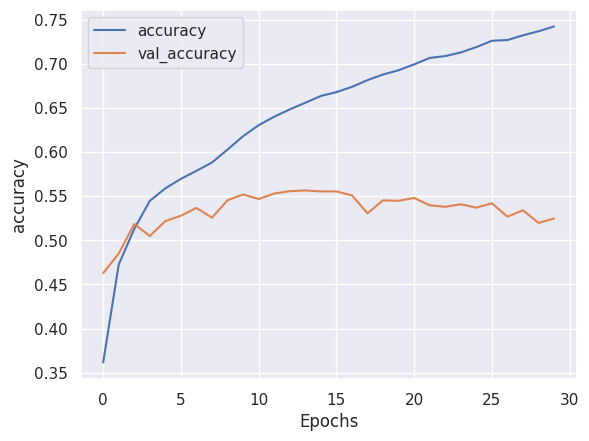

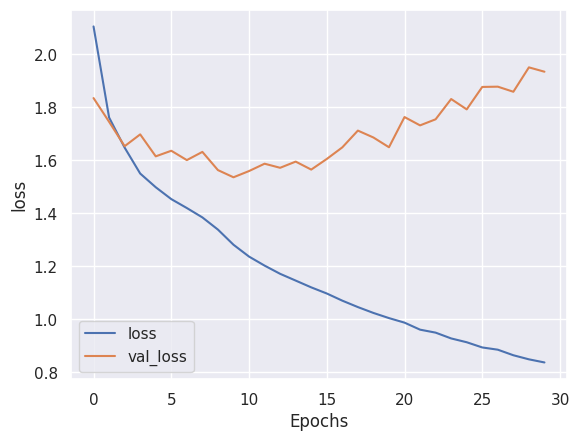

In [27]:
def plot_graphs(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history[f'val_{metric}'])
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, f'val_{metric}'])
    plt.show()

plot_graphs(history, "accuracy")
plot_graphs(history, "loss")